### FNO_GPT_DNA2DNA_model_3_single_triple

1.	We feed single-nucleotide data (one-hot) into the FNO, yielding a (batch, 512)-dim embedding.
2.	We feed triplet-coded data into the GPT.
3.	We concatenate the GPT token embeddings with the FNO embedding for each token, then apply a linear fusion layer (512 + 512 → 512).
4.	All model parameters (FNO + GPT) update via the cross-entropy loss for next-codon prediction.

In [4]:
"""
Unfrozen FNO + GPT (No Pretrained Checkpoints)
----------------------------------------------
A single script that trains from scratch:
 - Single-nucleotide => FNO => 512-d embedding
 - Triplet-coded => GPT => next-codon
 - Concat & fuse => Full training.

No references to pre-existing checkpoints or 'max_len' in GPT constructor.
"""

import os
import re
import math
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split

In [5]:
###############################################################################
# 1) FASTA => 768-bp Chunks
###############################################################################
def parse_fasta_and_chunk(fasta_path, chunk_size=768, max_samples=25000):
    seq_parts = []
    with open(fasta_path, 'r') as f:
        for line in f:
            if line.startswith(">"):
                continue
            seq_parts.append(line.strip())
    full_seq = "".join(seq_parts).upper()

    # If you want codon alignment
    remainder = len(full_seq) % 3
    if remainder != 0:
        full_seq = full_seq[:-remainder]

    chunks = [full_seq[i : i+chunk_size] for i in range(0,len(full_seq),chunk_size)]
    chunks = [c for c in chunks if len(c)==chunk_size]

    if len(chunks)>max_samples:
        random.shuffle(chunks)
        chunks= chunks[:max_samples]
    return chunks

def build_dna_dataframe(dna_chunks):
    return pd.DataFrame(dna_chunks, columns=["dna_sequence"])

In [6]:
###############################################################################
# 2) Triplet Codon Tokenization
###############################################################################
def tokenize_triplets(dna_str):
    codons= [dna_str[i:i+3] for i in range(0,len(dna_str),3)]
    valid = set([
        'AAA','AAT','AAG','AAC','ATA','ATT','ATG','ATC',
        'AGA','AGT','AGG','AGC','ACA','ACT','ACG','ACC',
        'TAA','TAT','TAG','TAC','TTA','TTT','TTG','TTC',
        'TGA','TGT','TGG','TGC','TCA','TCT','TCG','TCC',
        'GAA','GAT','GAG','GAC','GTA','GTT','GTG','GTC',
        'GGA','GGT','GGG','GGC','GCA','GCT','GCG','GCC',
        'CAA','CAT','CAG','CAC','CTA','CTT','CTG','CTC',
        'CGA','CGT','CGG','CGC','CCA','CCT','CCG','CCC','N'
    ])
    return [c if c in valid else '<unk>' for c in codons]

def build_triplet_vocab(tokenized_list):
    all_tokens = set()
    for seq in tokenized_list:
        all_tokens.update(seq)
    all_tokens= sorted(list(all_tokens))
    char_to_idx = {tok: i+1 for i,tok in enumerate(all_tokens)}
    char_to_idx['<pad>'] = 0
    idx_to_char = {v:k for k,v in char_to_idx.items()}
    return char_to_idx, idx_to_char

def encode_triplets(dna_str, char_to_idx):
    tokens= tokenize_triplets(dna_str)
    return [char_to_idx.get(t,char_to_idx.get('<unk>',0)) for t in tokens]




In [7]:
###############################################################################
# 3) Single-nuc for FNO
###############################################################################
dna_pattern= re.compile(r"[ATGCN]")
def tokenize_single_nuc(seq):
    return dna_pattern.findall(seq.upper())

def build_single_nuc_vocab():
    """
    Minimal => {<pad>:0, A:1, T:2, G:3, C:4, N:5}
    """
    return {'<pad>':0,'A':1,'T':2,'G':3,'C':4,'N':5}

def encode_single_nuc(seq, nuc_vocab):
    tokens= tokenize_single_nuc(seq)
    return [nuc_vocab.get(t,0) for t in tokens]

def one_hot_encode(seq_idx, vocab_size):
    arr= np.zeros((len(seq_idx), vocab_size), dtype=np.float32)
    for i, idx in enumerate(seq_idx):
        arr[i, idx]=1.0
    return arr



In [8]:
###############################################################################
# 4) Fourier Neural Operator
###############################################################################
class FourierLayer(nn.Module):
    def __init__(self, modes, width):
        super().__init__()
        self.modes= modes
        self.width= width
        self.scale= 1.0/(width**2)
        self.weights_real= nn.Parameter(self.scale* torch.randn(modes,width))
        self.weights_imag= nn.Parameter(self.scale* torch.randn(modes,width))

    def forward(self, x):
        """
        x => (batch, width, seq_len)
        """
        x_ft= torch.fft.rfft(x, dim=-1)
        x_ft= x_ft[:, :, :self.modes]

        out_ft= torch.zeros_like(x_ft,dtype=torch.cfloat)
        out_ft.real= x_ft.real* self.weights_real.unsqueeze(0).transpose(1,2)
        out_ft.imag= x_ft.imag* self.weights_imag.unsqueeze(0).transpose(1,2)

        x_out= torch.fft.irfft(out_ft, n=x.size(-1),dim=-1)
        return x_out

class FourierNeuralOperator(nn.Module):
    """
    We'll produce => (batch, seq_len, 256), then mean-pool => (batch,256)
    """
    def __init__(self, modes, width, input_dim, output_dim):
        super().__init__()
        self.modes= modes
        self.width= width
        self.input_dim= input_dim
        self.output_dim= output_dim

        self.fc_in= nn.Linear(input_dim,width)
        self.layers= nn.ModuleList([FourierLayer(modes,width) for _ in range(4)])
        self.dropout= nn.Dropout(0.1)
        self.fc_out= nn.Linear(width,output_dim)
        self.activation= nn.GELU()

    def forward(self, x):
        """
        x => (batch, seq_len, input_dim)
        returns => (batch, output_dim) after mean-pool
        """
        x= self.fc_in(x)    # => (batch, seq_len, width)
        x= self.activation(x)

        x= x.transpose(1,2) # => (batch, width, seq_len)
        for layer in self.layers:
            y= layer(x)
            y= self.activation(y)
            y= self.dropout(y)
            x= x + y   # skip

        x= x.transpose(1,2) # =>(batch, seq_len, width)
        x= self.fc_out(x)   # =>(batch, seq_len, output_dim)
        # mean across seq_len
        x= x.mean(dim=1)    # =>(batch, output_dim)
        return x


In [10]:
###############################################################################
# 5) GPT for Triplets (Concat-Fusion)
###############################################################################
class PositionalEncoding(nn.Module):
    def __init__(self, d_model):
        super().__init__()
        max_len= 1024
        pe= torch.zeros(max_len,d_model)
        position= torch.arange(0,max_len,dtype=torch.float32).unsqueeze(1)
        div_term= torch.exp(-torch.arange(0,d_model,2).float()*(math.log(10000.0)/d_model))
        pe[:,0::2]= torch.sin(position*div_term)
        pe[:,1::2]= torch.cos(position*div_term)
        pe= pe.unsqueeze(0) #(1,max_len,d_model)
        self.register_buffer("pe",pe)

    def forward(self,x):
        seq_len= x.size(1)
        x= x + self.pe[:,:seq_len,:].to(x.device)
        return x

class DNAGPT_Triplet_Fusion(nn.Module):
    """
    GPT that fuses a 256-d embedding from the FNO
    """
    def __init__(self, vocab_size=100, embedding_dim=512, nhead=8, num_layers=4, dropout=0.1):
        super().__init__()
        self.token_embedding= nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        self.pos_encoder= PositionalEncoding(embedding_dim)

        # Concat => 512+512 => 1024 => linear => 512
        self.fusion_linear= nn.Linear(embedding_dim*2, embedding_dim)

        enc_layer= nn.TransformerEncoderLayer(d_model=embedding_dim,nhead=nhead,
                                              batch_first=True,dropout=dropout)
        self.transformer_encoder= nn.TransformerEncoder(enc_layer,num_layers=num_layers)

        self.dropout= nn.Dropout(dropout)
        self.fc_out= nn.Linear(embedding_dim,vocab_size)

    def generate_square_subsequent_mask(self, sz):
        mask= torch.triu(torch.ones(sz,sz), diagonal=1).bool()
        return mask.to(next(self.parameters()).device)

    def forward(self, src, fno_emb=None):
        """
        src => (batch, seq_len)
        fno_emb => (batch, 768)
        """
        x= self.token_embedding(src)  # => (batch, seq_len, 256)
        x= self.pos_encoder(x)

        if fno_emb is not None:
            # expand => (batch,seq_len,256)
            exp= fno_emb.unsqueeze(1).repeat(1,x.size(1),1)
            cat= torch.cat([x,exp],dim=-1) # =>(batch, seq_len,512)
            x= self.fusion_linear(cat)     # =>(batch, seq_len,256)

        mask= self.generate_square_subsequent_mask(src.size(1))
        hidden= self.transformer_encoder(x,mask=mask)
        hidden= self.dropout(hidden)
        logits= self.fc_out(hidden)   # =>(batch, seq_len, vocab_size)
        return logits

In [11]:
###############################################################################
# 6) Combined FNO+GPT Model
###############################################################################
class FNOPlusGPT(nn.Module):
    def __init__(self, fno, gpt):
        super().__init__()
        self.fno= fno   # trainable
        self.gpt= gpt   # trainable

In [12]:
###############################################################################
# 7) Dataset
###############################################################################
class FNOGPTDataset(Dataset):
    """
    For each chunk => single-nuc => FNO => embedding => GPT => next-codon
    We do next-token pred in GPT.
    """
    def __init__(self, df, nuc_vocab, trip_vocab, max_trip_len=85):
        super().__init__()
        self.df= df.reset_index(drop=True)
        self.nuc_vocab= nuc_vocab
        self.trip_vocab= trip_vocab
        self.max_trip_len= max_trip_len

        self.nuc_encoded= []
        self.trip_encoded_padded= []
        for seq in self.df["dna_sequence"]:
            # single-nuc
            nuc_idx= encode_single_nuc(seq, self.nuc_vocab)
            self.nuc_encoded.append(nuc_idx)

            # trip
            trip_idx= encode_triplets(seq, self.trip_vocab)
            pad_len= self.max_trip_len - len(trip_idx)
            trip_idx += [0]*pad_len
            self.trip_encoded_padded.append(trip_idx)

        self.trip_encoded_padded= torch.tensor(self.trip_encoded_padded, dtype=torch.long)

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        nuc_seq= self.nuc_encoded[idx]
        trip_seq= self.trip_encoded_padded[idx]
        input_seq= trip_seq[:-1]
        target_seq= trip_seq[1:]
        return nuc_seq, input_seq, target_seq

def fnogpt_collate_fn(batch):
    nuc_list= []
    gpt_in_list= []
    gpt_tgt_list= []
    for (nuc_seq, in_seq, tgt_seq) in batch:
        nuc_list.append(nuc_seq)
        gpt_in_list.append(in_seq)
        gpt_tgt_list.append(tgt_seq)
    gpt_in_tensor= torch.stack(gpt_in_list, dim=0)
    gpt_tgt_tensor= torch.stack(gpt_tgt_list,dim=0)
    return nuc_list, gpt_in_tensor, gpt_tgt_tensor

In [13]:
###############################################################################
# 8) Training and Evaluation
###############################################################################
def compute_accuracy(logits, targets, pad_idx=0):
    with torch.no_grad():
        preds= logits.argmax(dim=-1).view(-1)
        targets= targets.view(-1)
        mask= (targets!=pad_idx)
        correct= (preds[mask]==targets[mask]).sum().item()
        total= mask.sum().item()
        return correct/total if total>0 else 0.0

def train_epoch(model, loader, optimizer, criterion, device, pad_idx=0):
    model.train()
    total_loss=0.0
    total_acc=0.0
    total_samples=0

    for nuc_seq_list, gpt_in, gpt_tgt in loader:
        batch_sz= gpt_in.size(0)
        gpt_in= gpt_in.to(device)
        gpt_tgt= gpt_tgt.to(device)

        # Step1: FNO => build one-hot => forward => (batch,256)
        emb_list= []
        for nuc_seq in nuc_seq_list:
            arr= one_hot_encode(nuc_seq,6)  # shape=(seq_len,6)
            x_tensor= torch.tensor(arr, dtype=torch.float32).unsqueeze(0).to(device)
            # => (1, seq_len, 6)
            fno_emb= model.fno(x_tensor)  # =>(1,256)
            emb_list.append(fno_emb)
        # => shape=(batch,256)
        batch_emb= torch.cat(emb_list,dim=0)

        optimizer.zero_grad()
        logits= model.gpt(gpt_in, fno_emb=batch_emb)
        # =>(batch, seq_len, vocab_size)
        logits_flat= logits.view(-1, logits.size(-1))
        gpt_tgt_flat= gpt_tgt.view(-1)
        loss= criterion(logits_flat, gpt_tgt_flat)
        loss.backward()
        optimizer.step()

        total_loss+= loss.item()*batch_sz
        acc= compute_accuracy(logits,gpt_tgt,pad_idx)
        total_acc+= acc*batch_sz
        total_samples+=batch_sz

    avg_loss= total_loss/total_samples
    avg_acc= total_acc/total_samples
    ppl= math.exp(avg_loss)
    return avg_loss, ppl, avg_acc

@torch.no_grad()
def eval_epoch(model, loader, criterion, device, pad_idx=0):
    model.eval()
    total_loss=0.0
    total_acc=0.0
    total_samples=0

    for nuc_seq_list, gpt_in, gpt_tgt in loader:
        batch_sz= gpt_in.size(0)
        gpt_in= gpt_in.to(device)
        gpt_tgt= gpt_tgt.to(device)

        emb_list= []
        for nuc_seq in nuc_seq_list:
            arr= one_hot_encode(nuc_seq,6)
            x_tensor= torch.tensor(arr,dtype=torch.float32).unsqueeze(0).to(device)
            fno_emb= model.fno(x_tensor)
            emb_list.append(fno_emb)
        batch_emb= torch.cat(emb_list, dim=0)

        logits= model.gpt(gpt_in, fno_emb=batch_emb)
        logits_flat= logits.view(-1, logits.size(-1))
        gpt_tgt_flat= gpt_tgt.view(-1)
        loss= criterion(logits_flat, gpt_tgt_flat)

        total_loss+= loss.item()*batch_sz
        acc= compute_accuracy(logits,gpt_tgt,pad_idx)
        total_acc+= acc*batch_sz
        total_samples+= batch_sz

    avg_loss= total_loss/total_samples
    avg_acc= total_acc/total_samples
    ppl= math.exp(avg_loss)
    return avg_loss, ppl, avg_acc

class EarlyStopping:
    def __init__(self, patience=15, verbose=False, delta=0, path='fno_gpt_unfrozen_best.pt'):
        self.patience= patience
        self.verbose= verbose
        self.counter= 0
        self.best_loss= None
        self.early_stop= False
        self.loss_min= np.Inf
        self.delta= delta
        self.path= path

    def __call__(self, val_loss, model):
        if self.best_loss is None:
            self.best_loss= val_loss
            self.save_checkpoint(val_loss, model)
        elif val_loss>self.best_loss + self.delta:
            self.counter+=1
            if self.verbose:
                print(f"EarlyStopping counter: {self.counter} of {self.patience}")
            if self.counter>=self.patience:
                self.early_stop= True
        else:
            self.best_loss= val_loss
            self.save_checkpoint(val_loss,model)
            self.counter= 0

    def save_checkpoint(self, val_loss, model):
        if self.verbose:
            print(f"Validation loss decreased ({self.loss_min:.6f} -> {val_loss:.6f}). Saving model...")
        torch.save(model.state_dict(), self.path)
        self.loss_min= val_loss


Using device: mps
Loaded chunks: 25000
Train: 20000 Val: 5000
Triplet vocab size: 66
FNO + GPT: All parameters trainable from scratch.
Epoch 1: TrainLoss=1.8180, ValLoss=1.7634, TrainPPL=6.16, ValPPL=5.83, TrainAcc=0.566, ValAcc=0.576
Validation loss decreased (inf -> 1.763374). Saving model...
Epoch 2: TrainLoss=1.7739, ValLoss=1.7325, TrainPPL=5.89, ValPPL=5.65, TrainAcc=0.574, ValAcc=0.584
Validation loss decreased (1.763374 -> 1.732482). Saving model...
Epoch 3: TrainLoss=1.7362, ValLoss=1.7040, TrainPPL=5.68, ValPPL=5.50, TrainAcc=0.583, ValAcc=0.590
Validation loss decreased (1.732482 -> 1.704008). Saving model...
Epoch 4: TrainLoss=1.7108, ValLoss=1.6843, TrainPPL=5.53, ValPPL=5.39, TrainAcc=0.588, ValAcc=0.594
Validation loss decreased (1.704008 -> 1.684306). Saving model...
Epoch 5: TrainLoss=1.6931, ValLoss=1.6718, TrainPPL=5.44, ValPPL=5.32, TrainAcc=0.591, ValAcc=0.597
Validation loss decreased (1.684306 -> 1.671843). Saving model...
Epoch 6: TrainLoss=1.6756, ValLoss=1.660

/var/folders/fw/cd1vxk4x57b1f2cpwmt7g49800k_fc/T/ipykernel_84946/742809406.py:104: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("fno_gpt_un

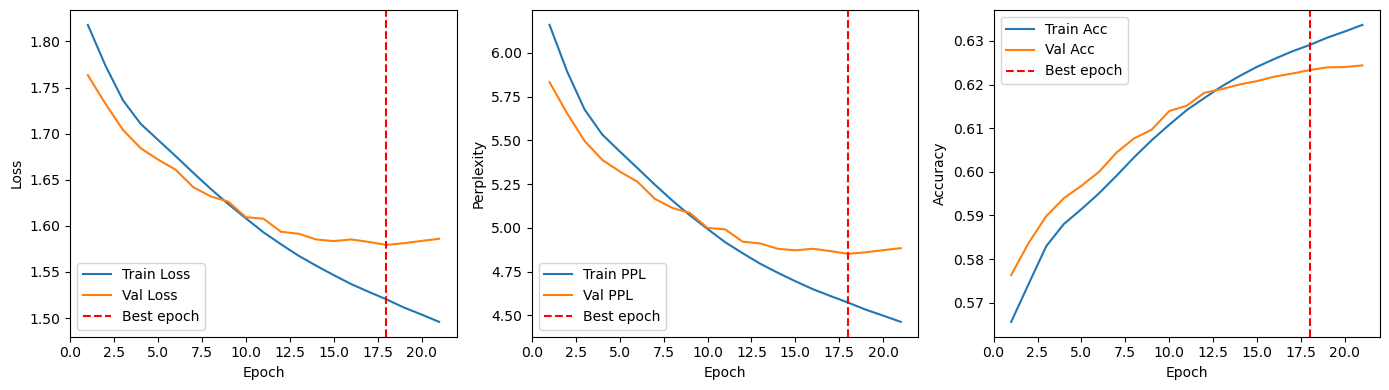

Saved final FNO+GPT unfrozen model to 'fno_gpt_unfrozen_final.pt'.


In [14]:
###############################################################################
# 9) MAIN
###############################################################################
def main():
    torch.manual_seed(42)
    np.random.seed(42)
    random.seed(42)

    # device= torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    device = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')
    print("Using device:",device)

    # A) FASTA => 768
    fasta_path= "Homo_sapiens.GRCh38.dna.chromosome.Y.fa"
    if not os.path.exists(fasta_path):
        raise FileNotFoundError(f"{fasta_path} not found")
    dna_chunks= parse_fasta_and_chunk(fasta_path, chunk_size=768, max_samples=25000)
    print("Loaded chunks:", len(dna_chunks))

    df_full= build_dna_dataframe(dna_chunks)
    df_train, df_val= train_test_split(df_full, test_size=0.2, random_state=42)
    print("Train:", len(df_train),"Val:", len(df_val))

    # B) Build triplet vocab
    all_trip= [tokenize_triplets(seq) for seq in df_full["dna_sequence"]]
    trip_char2idx, trip_idx2char= build_triplet_vocab(all_trip)
    vocab_size= len(trip_char2idx)
    print("Triplet vocab size:", vocab_size)

    # single-nuc vocab => e.g. 6 tokens
    nuc_vocab= build_single_nuc_vocab()

    # find max #codons in the train set
    max_trip_len= max(len(encode_triplets(seq, trip_char2idx)) for seq in df_train["dna_sequence"])
    train_dataset= FNOGPTDataset(df_train,nuc_vocab,trip_char2idx,max_trip_len)
    val_dataset=   FNOGPTDataset(df_val,  nuc_vocab,trip_char2idx,max_trip_len)

    train_loader= DataLoader(
        train_dataset,batch_size=8,shuffle=True,collate_fn=fnogpt_collate_fn
    )
    val_loader= DataLoader(
        val_dataset,batch_size=8,shuffle=False,collate_fn=fnogpt_collate_fn
    )

    # C) Define FNO
    fno_model= FourierNeuralOperator(
        modes=16, width=64,
        input_dim=6,  # single-nuc vocab size => 6
        output_dim=512
    ).to(device)

    # D) Define GPT
    gpt_model= DNAGPT_Triplet_Fusion(
        vocab_size=vocab_size,
        embedding_dim=512,
        nhead=8,
        num_layers=4,
        dropout=0.1
    ).to(device)

    # E) Combine => train everything
    class FNOTripletAllTrain(nn.Module):
        def __init__(self, fno, gpt):
            super().__init__()
            self.fno= fno  # trainable
            self.gpt= gpt  # trainable

    model= FNOTripletAllTrain(fno_model,gpt_model).to(device)
    print("FNO + GPT: All parameters trainable from scratch.")

    # F) Training Setup
    optimizer= optim.AdamW(model.parameters(), lr=1e-4)
    criterion= nn.CrossEntropyLoss(ignore_index=trip_char2idx['<pad>'])
    early_stopper= EarlyStopping(patience=3, verbose=True, path="fno_gpt_unfrozen_best.pt")

    # G) Training Loop
    epochs=200
    train_losses, val_losses= [], []
    train_ppls, val_ppls= [], []
    train_accs, val_accs= [], []

    for ep in range(1, epochs+1):
        tr_loss, tr_ppl, tr_acc= train_epoch(model, train_loader, optimizer, criterion, device, pad_idx=0)
        va_loss, va_ppl, va_acc= eval_epoch(model, val_loader, criterion, device, pad_idx=0)

        train_losses.append(tr_loss)
        val_losses.append(va_loss)
        train_ppls.append(tr_ppl)
        val_ppls.append(va_ppl)
        train_accs.append(tr_acc)
        val_accs.append(va_acc)

        print(f"Epoch {ep}: "
              f"TrainLoss={tr_loss:.4f}, ValLoss={va_loss:.4f}, "
              f"TrainPPL={tr_ppl:.2f}, ValPPL={va_ppl:.2f}, "
              f"TrainAcc={tr_acc:.3f}, ValAcc={va_acc:.3f}")

        early_stopper(va_loss,model)
        if early_stopper.early_stop:
            print("Early stopping triggered.")
            break

    # Load best
    model.load_state_dict(torch.load("fno_gpt_unfrozen_best.pt", map_location=device))
    print("Loaded best checkpoint from 'fno_gpt_unfrozen_best.pt'.")

    # H) Plot
    x_ep= range(1,len(train_losses)+1)
    plt.figure(figsize=(14,4))

    plt.subplot(1,3,1)
    plt.plot(x_ep, train_losses,label='Train Loss')
    plt.plot(x_ep, val_losses,label='Val Loss')
    best_ep= np.argmin(val_losses)+1
    plt.axvline(best_ep, color='r', linestyle='--', label='Best epoch')
    plt.xlabel("Epoch");plt.ylabel("Loss");plt.legend()

    plt.subplot(1,3,2)
    plt.plot(x_ep, train_ppls,label='Train PPL')
    plt.plot(x_ep, val_ppls,label='Val PPL')
    plt.axvline(best_ep, color='r', linestyle='--', label='Best epoch')
    plt.xlabel("Epoch");plt.ylabel("Perplexity");plt.legend()

    plt.subplot(1,3,3)
    plt.plot(x_ep, train_accs,label='Train Acc')
    plt.plot(x_ep, val_accs,label='Val Acc')
    plt.axvline(best_ep, color='r', linestyle='--', label='Best epoch')
    plt.xlabel("Epoch");plt.ylabel("Accuracy");plt.legend()

    plt.tight_layout()
    plt.show()

    # I) Save Final
    torch.save(model.state_dict(),"fno_gpt_unfrozen_final.pt")
    print("Saved final FNO+GPT unfrozen model to 'fno_gpt_unfrozen_final.pt'.")


if __name__=="__main__":
    main()